Практика по проверке АБ-тестов.
Цель: Используя данные https://www.kaggle.com/zhangluyuan/ab-testing провести анализ ab-теста на различие в двух выборках

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy
from statsmodels.stats.weightstats import *

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.shape

(294478, 5)

In [5]:
df.user_id.nunique()

290584

We have unique 290584 user_id, but 294478 rows. Since we can only perform AB testing for independent samples, we will have to remove accidentally duplicated users.

In [6]:
df.describe(include = 'O')

,timestamp,group,landing_page
count,294478,294478,294478
unique,294478,2,2
top,2017-01-20 14:09:44.087174,treatment,old_page
freq,1,147276,147239


In [7]:
# Checking to see if there are any users in control that saw new page and users in treatment that saw old page
df.groupby(['group','landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

Some users from the control sample saw the new page, and some users from the treatment saw the old version of the page.  
Since we're not sure which way to switch it to, we're going to remove it.

In [8]:
# Removing control/new_page and treatment/old_page
df_clean = df.loc[(df['group'] == 'control') & (df['landing_page'] == 'old_page') | 
                    (df['group'] == 'treatment') & (df['landing_page'] == 'new_page') ]

In [9]:
df_clean.groupby(['group','landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


Let's double-check that all users in the sample are unique.

In [10]:
df_clean['user_id'].duplicated().sum()

1

In [11]:
df_clean[df_clean.duplicated(['user_id'],keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

In [12]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
df_clean = df_clean.drop_duplicates(subset='user_id', keep="first")
df_clean['user_id'].duplicated().sum()

0

We now have truly independent samples. 
Let's look at distributions.

<BarContainer object of 2 artists>

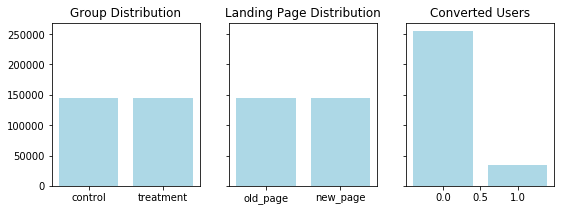

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].set_title('Group Distribution')
axs[0].bar(df_clean.group.unique(), df_clean.group.value_counts(), color = 'lightblue')

axs[1].set_title('Landing Page Distribution')
axs[1].bar(df_clean.landing_page.unique(), df_clean.landing_page.value_counts(), color = 'lightblue')

axs[2].set_title('Converted Users')
axs[2].bar(df_clean.converted.unique(), df_clean.converted.value_counts(), color = 'lightblue')

What is the conversion rate for "Control" and "Treatment" groups?

In [15]:
# conversation rate for control group
a_group_conversation = df_clean[
    (df_clean['group'] == 'control') & (df_clean['converted'] == 1)].shape[0] / df_clean[df_clean['group'] == 'control'].shape[0]

print('Conversation rate for control group :', a_group_conversation)

Conversation rate for control group : 0.1203863045004612


In [16]:
# conversation rate for control group
b_group_conversation = df_clean[
    (df_clean['group'] == 'treatment') & (df_clean['converted'] == 1)].shape[0] / df_clean[df_clean['group'] == 'treatment'].shape[0]

print('Conversation rate for treatment group :', b_group_conversation)

Conversation rate for treatment group : 0.11880806551510564


Conversation rate for the 'Control' group is a little bit higher. Does it mean that our old page is better than the new one? Let's check.

### A/B test

In [17]:
num_a, num_b = df_clean[df_clean['landing_page']=='new_page'].shape[0], df_clean[df_clean['landing_page'] == 'old_page'].shape[0]
click_a = df_clean[(df_clean['landing_page'] == 'new_page') & (df_clean['converted'] == 1)].shape[0]
click_b = df_clean[(df_clean['landing_page'] == 'old_page') & (df_clean['converted'] == 1)].shape[0]
rate_a, rate_b = click_a / num_a, click_b / num_b

In [18]:
rate_a, rate_b

(0.11880806551510564, 0.1203863045004612)

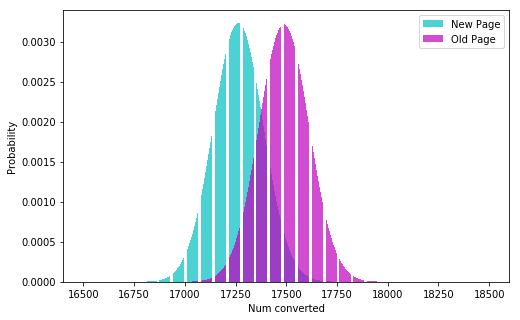

In [19]:
from scipy.stats import binom

# Determine the probability of having x number of click throughs

# Mean converted users for the whole dataset is about ~17300
clicks = np.arange(16500, 18500)
prob_a = binom(num_a, rate_a).pmf(clicks)
prob_b = binom(num_b, rate_b).pmf(clicks)

# Make the bar plots.
plt.figure(figsize = (8,5))
plt.bar(clicks, prob_a, label="New Page", alpha=0.7, color = 'c')
plt.bar(clicks, prob_b, label="Old Page", alpha=0.7, color = 'm')
plt.legend()
plt.xlabel("Num converted"); 
plt.ylabel("Probability");

So we can see here that b has an edge, but its certaintly possible if we pick two random points according to the histograms for A and B, that old page might actually be higher than new one!

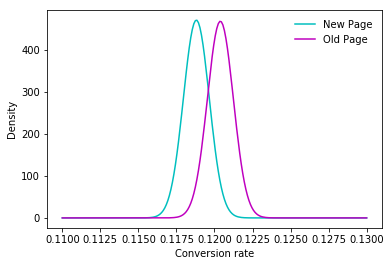

In [20]:
from scipy.stats import norm

# Where does this come from? See the link above.
std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

# mean conversity rate is approximately ~0.12
click_rate = np.linspace(0.11, 0.13, 200)
prob_a = norm(rate_a, std_a).pdf(click_rate)
prob_b = norm(rate_b, std_b).pdf(click_rate)

# Make the bar plots.
plt.plot(click_rate, prob_a, label="New Page", color = 'c')
plt.plot(click_rate, prob_b, label="Old Page", color = 'm')
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); 
plt.ylabel("Density");

As we can see from the chart the old page has more conversion rate than the new one.
Let's double check it with z-score. 

Null hypotesis:

$H_0\colon$  A_conversion_rate - B_conversion_rate >= 0


Alternative hypotesis:

$H_1\colon$ A_conversion_rate - B_conversion_rate < 0

zscore is 1.311, with p-value 0.095


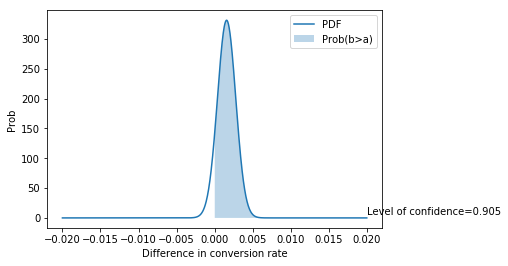

In [21]:
z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
p = norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))

x = np.linspace(-0.02, 0.02, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Level of confidence={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); 
plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

Great! So, how to phrase this result? Using our frequentist approach so far, we would say that given the null hypothesis is true (that B is less then or equal to A), we would expect to get this result or a result more extreme only 9.5% of the time. As that is a significant result (typically p < 10%), we reject the null hypothesis, and state that we have evidence that B > A.